# 텍스트 분류 모델 만들기

![Screenshot 2024-01-25 at 3.08.44 PM.png](<attachment:Screenshot 2024-01-25 at 3.08.44 PM.png>)
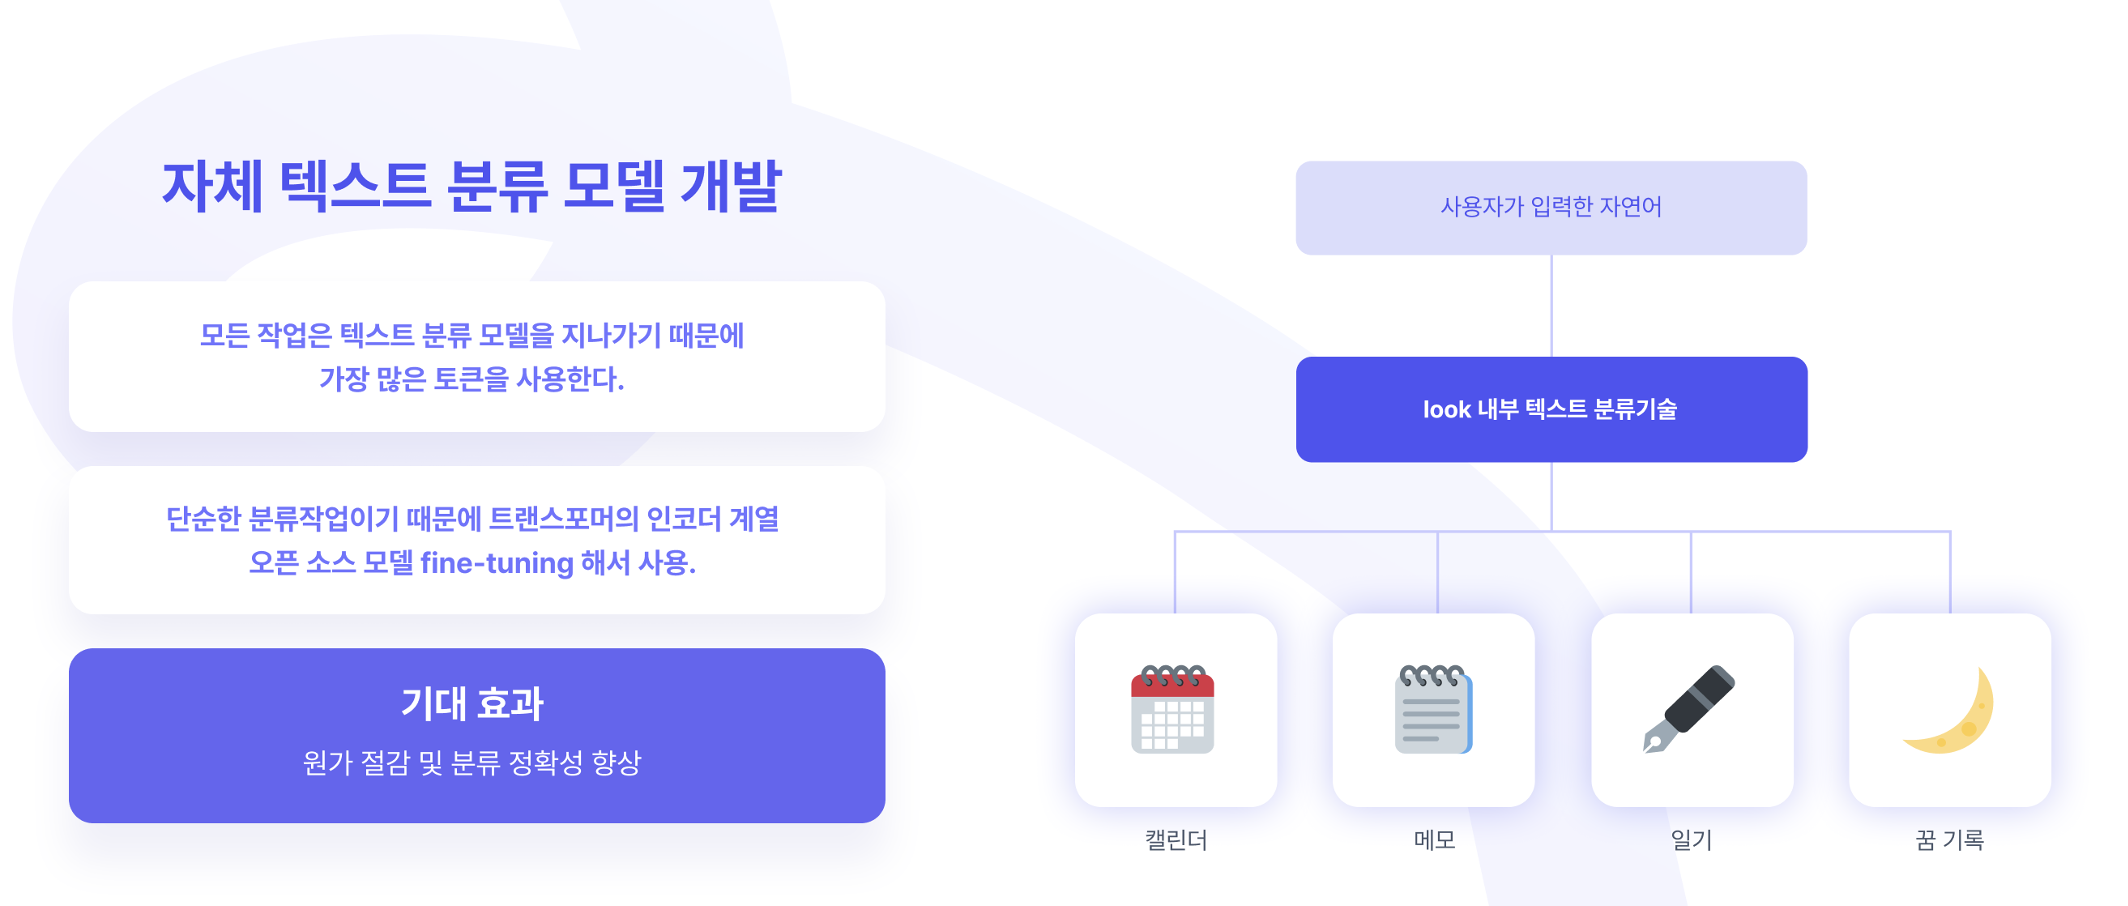

## 다음과 같은 순서로 진행합니다.

1. 데이터셋 라벨링
2. 데이터셋 로드
3. 모델링
4. 모델 훈련
5. 모델 평가

### 데이터셋 라벨링

- 서비스에서 gpt-4-turbo모델로 분류한 데이터셋을 불러옵니다.
- 약 2600개의 데이터를 직접 검수하여 라벨링합니다.

![Screenshot 2024-01-24 at 4.51.36 PM.png](<attachment:Screenshot 2024-01-24 at 4.51.36 PM.png>)
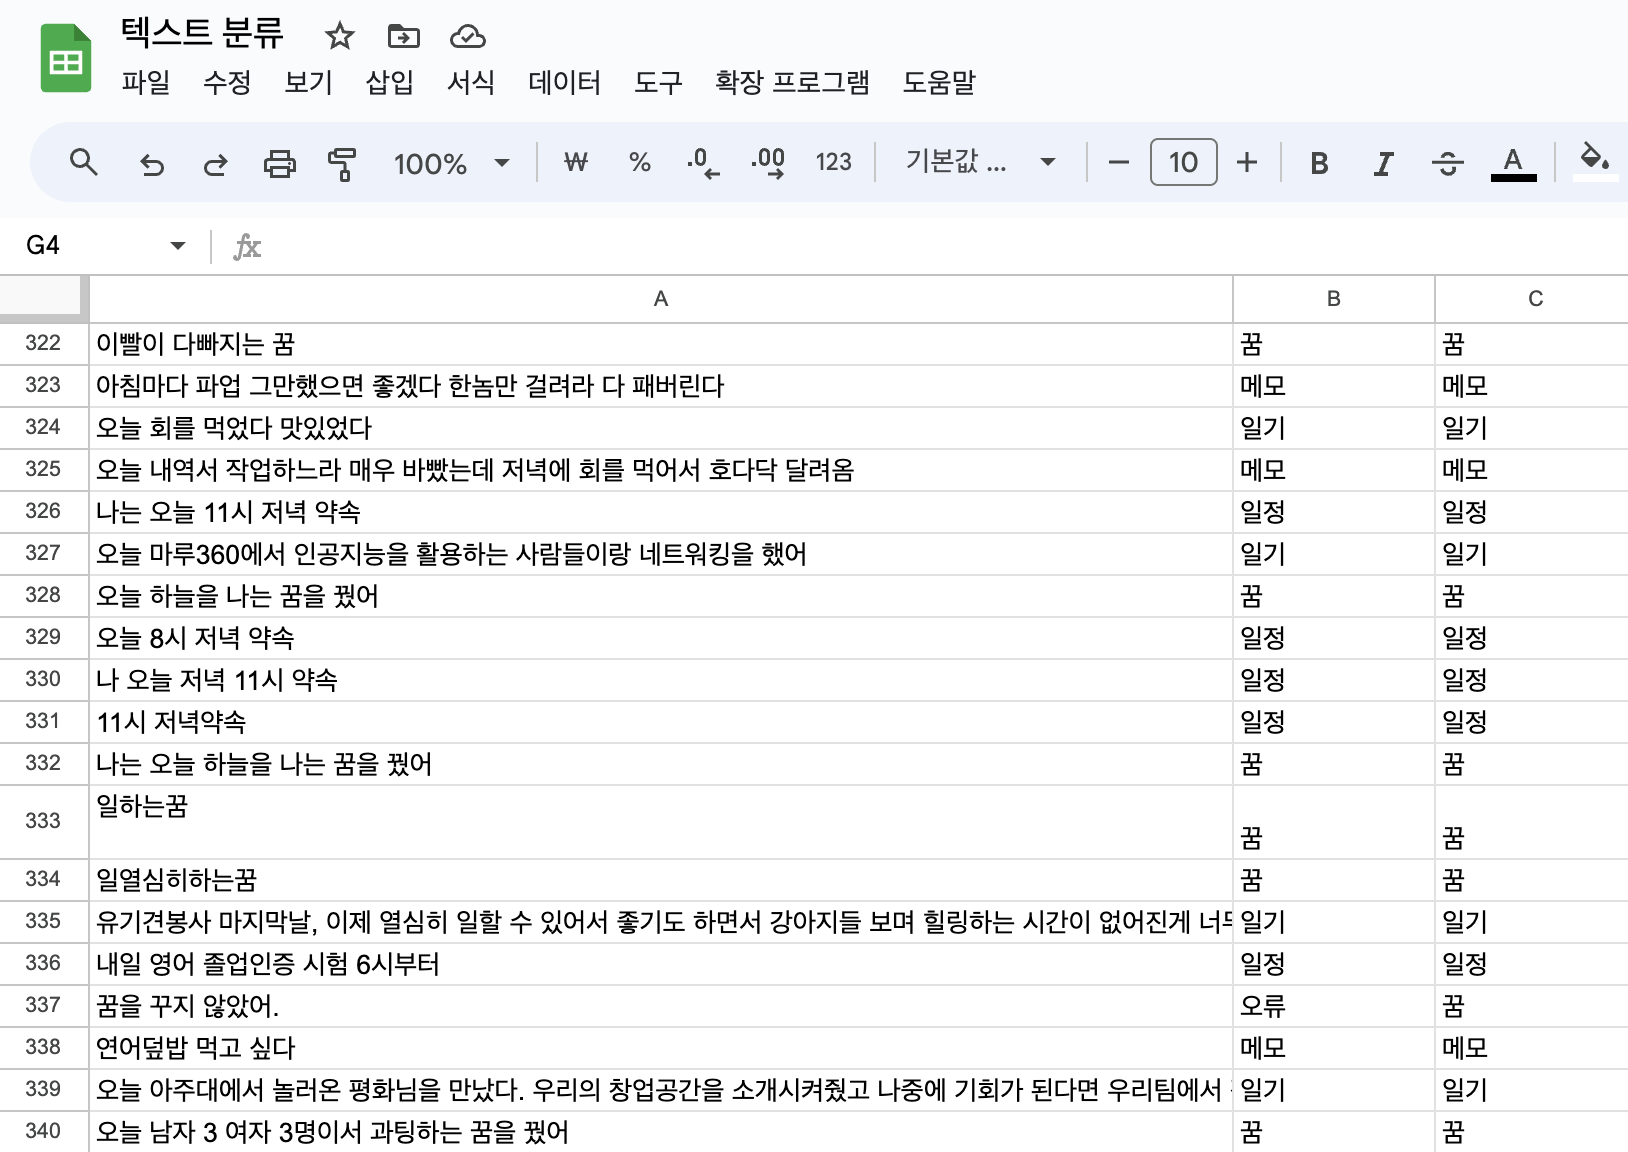

In [15]:
!pip install torch
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install scikit-learn

In [16]:
!nvidia-smi

Thu Jan 25 17:17:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   38C    P8              33W / 450W |   5476MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 데이터셋 로드

- 라벨링한 데이터셋을 불러옵니다.
- gpt-4-turbo모델로 분류한 데이터셋의 f1-score를 확인합니다. (macro avg)
- 데이터셋을 train, test로 분리합니다.
- train셋을 stratified k-fold로 분리합니다.

In [ ]:
# 기존에 gpt-4-turbo 모델로 사용자의 텍스트를 분류하는 prompt

prompt = [
    {"role": "system", "content": "사용자의 텍스트가 꿈, 일기, 메모, 일정 중 어떤 카테고리인지 분류해서 숫자만 반환해줘. 꿈 = 1, 일기 = 2, 메모 = 3, 일정 = 4"},
    {"role": "system", "content": "내용이 짧으면 메모 또는 일정일 확률이 높고, 꿈이라는 단어가 포함되면 꿈, 오늘 내가 한 일들과 생각들이 포함되면 일기일 확률이 높다."},
    {"role": "system", "content": "날짜와 관련된 단어가 포함되면 일정일 확률이 높다."},
    {"role": "system", "content": "나머지는 메모로 분류해줘. return 1, 2, 3, 4"},
    {"role": "user", "content": "엄청나게 맑고 깨끗한 낚시터에서 낚시했는데 어찌나 투명한지 물고기가 다 보이는 꿈"},
    {"role": "system", "content": "1"},
    {"role": "user", "content": "오늘은 하루종일 코딩을 했다. 내가 만든 코드는 잘 돌아가지 않고, 너무 고통받았다. 내일은 개발을 마무리해서 얼른 서비스를 출시하고 싶다"},
    {"role": "system", "content": "2"},
    {"role": "user", "content": "엘리스 세습 책 읽기, 56쪽"},
    {"role": "system", "content": "3"},
    {"role": "user", "content": "8월25일 저녁6시 강남 약속"},
    {"role": "system", "content": "4"},
    {"role": "user", "content": "오늘은 크리스마스다. 여자친구와 현대백화점에 가서 아웃백을 먹고 영화를 봤다. 오펜하이머를 봤는데 나는 사실 물리학과를 갔어야 될 것 같다. 너무 재미있었다."},
    {"role": "system", "content": "2"},
    {"role": "user", "content": "다음주 금요일 6시에 중앙도서관 앞에서 자동차 동아리 모임이 있어"},
    {"role": "system", "content": "4"},
    {"role": "user", "content": "스키장에서 스키를 타고 있는데 뒤에서 곰이 갑자기 튀어나와서 도망가다가 넘어지고, 꿈에서 깼어"},
    {"role": "system", "content": "1"},
    {"role": "user", "content": "꿈에서 어떤 길에서 있었는데 하을을 올려보니 보름달이 구름에 가려져 빛나고 있었다. 구름에 가려졌지만 밝게 빛나고 있어서 보름달이 잘 보였다. 보름달은 이내 구름 위로 솟아 올라 밝게 빛났다."},
    {"role": "system", "content": "1"},
    {"role": "user", "content": "학교에서 계속 공부를했다. 너무 힘든 하루였지만 마무리가 깔끔해서 기분좋게 잠에 잘 수 있을 것 같다. 내일은 더 열심히 해야겠다."},
    {"role": "system", "content": "2"},
    {"role": "user", "content": "11월 20일부터 28일은 부산으로 여행갈거야"},
    {"role": "system", "content": "4"},
    {"role": "user", "content": "오늘 내역서 작업하느라 매우 바빴는데 저녁에 회를 먹어서 호다닥 달려옴"},
    {"role": "system", "content": "2"},
    {"role": "user", "content": "아침마다 파업 그만했으면 좋겠다 한놈만 걸려라 다 패버린다"},
    {"role": "system", "content": "2"},
]

In [17]:
import pandas as pd

file_path = '/media/mydrive/datasets/text_classification.csv'
df = pd.read_csv(file_path)

df.head()

,text,labeled_output,output
0,오늘은 소망 누나랑 자전거를 탔다. 날씨가 참 좋았다,일기,일기
1,소망누나랑 자전거를 타는 꿈을 꿨어,꿈,꿈
2,소망누나랑 자전거를 타는 꿈을 꿨어,꿈,꿈
3,"오늘은 팀원들이랑 열심히 회의했고, 만족스러운 하루였다.",일기,일기
4,산에서 곰이 내려와서 우리집 문을 부시고 가는 꿈을 꿨어,꿈,꿈


In [18]:
total_count = df.shape[0]
difference_count = (df['labeled_output'] != df['output']).sum()

print(f"Total number of rows: {total_count}")
print(f"Number of differences: {difference_count}")
print(f"Correct ratio of GPT: {100 - (difference_count / total_count * 100)}%")

Total number of rows: 2678
Number of differences: 462
Correct ratio of GPT: 82.74831964152352%


In [19]:
from sklearn.metrics import f1_score

# 레이블과 예측 결과를 리스트 형태로 변환
labels = df['labeled_output'].tolist()
predictions = df['output'].tolist()

# F1 스코어 계산
f1 = f1_score(labels, predictions, average='macro')  # 'macro'는 클래스 불균형을 고려하지 않음
print(f"F1 Score: {f1}")

F1 Score: 0.6730143123728515


In [20]:
print("GPT output distribution:")
df['output'].value_counts()

GPT output distribution:


output
꿈     704
일정    698
일기    674
메모    602
Name: count, dtype: int64

In [21]:
print("Labeled output distribution:")

df['labeled_output'].value_counts()

Labeled output distribution:


labeled_output
일기    729
일정    729
꿈     655
메모    377
오류    188
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import json

# 전체 데이터셋을 훈련 세트와 테스트 세트로 분리
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 훈련 세트를 섞음
train_df = train_df.sample(frac=1).reset_index(drop=True)

# StratifiedKFold 인스턴스 생성
kf = StratifiedKFold(n_splits=5)

# 훈련 세트의 Fold 별로 데이터를 나누고 jsonl 파일로 저장
for fold, (train_index, test_index) in enumerate(kf.split(train_df, train_df['labeled_output']), 1):
    fold_data = train_df.iloc[test_index]

    file_name = f'/media/mydrive/datasets/text_classification_train_fold_{fold}.jsonl'
    with open(file_name, 'w', encoding='utf-8') as f:
        for i, (_, row) in enumerate(fold_data.iterrows()):
            if type(row["text"]) != str:
                continue 
            data = {"id": i, "input": row['text'], "output": row['labeled_output']}
            json.dump(data, f, ensure_ascii=False)
            f.write('\n')

    print(f'Train Fold {fold} 저장 완료: {file_name}')

# 테스트 세트를 jsonl 파일로 저장
test_file_name = '/media/mydrive/datasets/text_classification_test.jsonl'
with open(test_file_name, 'w', encoding='utf-8') as f:
    for i, (_, row) in enumerate(test_df.iterrows()):
        if type(row["text"]) != str:
            continue 
        data = {"id": i, "input": row['text'], "output": row['labeled_output']}
        json.dump(data, f, ensure_ascii=False)
        f.write('\n')

print(f'Test 데이터셋 저장 완료: {test_file_name}')

Train Fold 1 저장 완료: /media/mydrive/datasets/text_classification_train_fold_1.jsonl
Train Fold 2 저장 완료: /media/mydrive/datasets/text_classification_train_fold_2.jsonl
Train Fold 3 저장 완료: /media/mydrive/datasets/text_classification_train_fold_3.jsonl
Train Fold 4 저장 완료: /media/mydrive/datasets/text_classification_train_fold_4.jsonl
Train Fold 5 저장 완료: /media/mydrive/datasets/text_classification_train_fold_5.jsonl
Test 데이터셋 저장 완료: /media/mydrive/datasets/text_classification_test.jsonl


In [23]:
print(f"훈련 데이터의 크기: {train_df.shape[0]}")
print(f"테스트 데이터의 크기: {test_df.shape[0]}")

# 데이터 하나 확인
with open('/media/mydrive/datasets/text_classification_fold_1.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        print(line)
        break

훈련 데이터의 크기: 2142
테스트 데이터의 크기: 536
{"id": 0, "input": "11월 22일에서 23일 오후 1시부터 오전 12시까지 강릉 여행", "output": "일정"}



### 모델링 및 모델 훈련
- huggingface에서 모델을 불러옵니다.
- 데이터셋을 토크나이징합니다.
- Stratified k-fold cross validation 방식으로 모델을 훈련합니다.
- early stopping을 적용합니다.
- f1-score를 확인합니다.(macro avg)

In [24]:
import json
from transformers import ElectraTokenizer, ElectraForSequenceClassification, ElectraConfig, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import f1_score
from datasets import Dataset, concatenate_datasets
from tqdm import tqdm
import wandb

In [25]:
# 라벨 매핑
label_map = {'꿈': 0, '일기': 1, '일정': 2, '메모': 3, '오류': 4}

#epoch 설정
epochs = 9999

# 학습률
lr = 1e-5

# early stopping 횟수
early_stop_patient = 5

# wandb 설정
weight_decay = 0.01

# k-fold 설정
k = 5

# 배치 사이즈
batch_size = 32

# 모델 이름
model_name = "beomi/KcELECTRA-base-v2022"


In [26]:
# wandb 설정
config = {
    "model_name": "beomi/KcELECTRA-base-v2022",
    "batch_size": batch_size,
    "epochs": epochs,
    "lr": lr,
    "wandb": True,
    "early_stop_patient" : early_stop_patient,
    "K-Fold" : '5'
}
wandb_name = f'{k}_{lr}_{batch_size}_text_classification'
wandb.init(project="text_classification", entity="taewan2002", name=wandb_name)

def load_and_process_data(file_path, label_map):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    texts = [item['input'] for item in data]
    label_list = [label_map[item['output']] for item in data]
    return texts, label_list


for kfold in range(1, k + 1):
    torch.cuda.empty_cache()
    print(f"Training for fold {kfold}")

    # 토크나이저 로드
    tokenizer = ElectraTokenizer.from_pretrained(model_name, cache_dir="/media/mydrive/base_models")

    # 데이터 토크나이징
    def tokenize_data(texts):
        # padding과 truncation을 True로 설정하면 배치 내 최대 길이로 패딩
        # return_tensors="pt"를 통해 PyTorch의 Tensor로 변환
        return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    
    def create_dataset(tokenized_data, labels):
        # input_ids, attention_mask를 텐서로 변환
        input_ids = tokenized_data['input_ids']
        attention_mask = tokenized_data['attention_mask']
        return TensorDataset(input_ids, attention_mask, torch.tensor(labels))
    
    dev_file = f"/media/mydrive/datasets/text_classification_fold_{kfold}.jsonl"
    train_files = [f"/media/mydrive/datasets/text_classification_fold_{i}.jsonl" for i in range(1, 6) if i != kfold]
    
    train_texts, train_labels = [], []
    for train_file in train_files:
        texts, labels = load_and_process_data(train_file, label_map)
        train_texts.extend(texts)
        train_labels.extend(labels)

    tokenized_train = tokenize_data(train_texts)
    train_dataset = create_dataset(tokenized_train, train_labels)

    dev_texts, dev_labels = load_and_process_data(dev_file, label_map)
    tokenized_dev = tokenize_data(dev_texts)
    dev_dataset = create_dataset(tokenized_dev, dev_labels)

    print(f"Train dataset: {len(train_dataset)}")
    print(f"Dev dataset: {len(dev_dataset)}")
    print(f"Train dataset label distribution: {torch.unique(train_dataset.tensors[2], return_counts=True)}")
    print(f"Dev dataset label distribution: {torch.unique(dev_dataset.tensors[2], return_counts=True)}")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    # cuda 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 모델 로드
    config = ElectraConfig.from_pretrained(model_name, cache_dir="/media/mydrive/base_models")
    config.hidden_dropout_prob = 0.2 # dropout 설정
    config.num_labels=len(label_map) # 라벨 개수 설정
    model = ElectraForSequenceClassification.from_pretrained(model_name, cache_dir="/media/mydrive/base_models", config=config, ).to(device)

    # optimizer 설정
    FULL_FINETUNING = True
    if FULL_FINETUNING:
        entity_property_param_optimizer = list(model.named_parameters()) # 모델의 파라미터를 불러옴
        no_decay = ['bias', 'LayerNorm.weight'] # 파라미터 중에서 weight decay를 적용하지 않을 파라미터를 설정
        entity_property_optimizer_grouped_parameters = [
            {'params': [p for n, p in entity_property_param_optimizer if not any(nd in n for nd in no_decay)],
                'weight_decay_rate': weight_decay},
            {'params': [p for n, p in entity_property_param_optimizer if any(nd in n for nd in no_decay)],
                'weight_decay_rate': 0.0}
        ] # weight decay를 적용할 파라미터와 적용하지 않을 파라미터를 그룹화
    optimizer = AdamW(entity_property_optimizer_grouped_parameters, lr=lr) # AdamW optimizer를 설정

    early_stop_counter = 0
    best_f1 = 0

    for epoch in range(epochs): # epoch만큼 반복, eraly stopping을 적용
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
            batch_input_ids, batch_attention_mask, batch_labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()


        print(f"Epoch {epoch + 1} | Train Loss: {total_loss / len(train_dataloader)}")

        # Evaluation
        model.eval()
        all_preds = []
        all_true = []

        with torch.no_grad(): # 평가할 때는 그래디언트 계산을 수행하지 않음
            for batch in dev_dataloader:
                batch_input_ids, batch_attention_mask, batch_labels = [b.to(device) for b in batch]
                
                outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # GPU에서 CPU로 옮기고 NumPy 배열로 변환

                all_preds.extend(preds)
                all_true.extend(batch_labels.cpu().numpy())  # GPU에서 CPU로 옮기고 NumPy 배열로 변환

                
        f1 = f1_score(all_true, all_preds, average = "macro") # F1 score 계산
        
        print(f"Epoch {epoch + 1} | Eval F1 score: {f1}")

        if f1 > best_f1:
            print("Best epoch ! saved the model")
            best_f1 = f1
            early_stop_counter = 0
            model.save_pretrained(f"/media/mydrive/models/text_classification/model_{kfold}")
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patient:
            break
            
        wandb.log({f"{kfold}fold_train_loss": total_loss / len(train_dataloader), f"{kfold}fold_eval_f1": f1})
        
    del model # 모델 삭제
    torch.cuda.empty_cache() # GPU 캐시 삭제
    print(f"Best F1 for {kfold}: {best_f1}")

1fold_eval_f1,▁▂▄▅▅▆▇▇███▇█
1fold_train_loss,█▆▄▃▃▂▂▂▂▁▁▁▁
2fold_eval_f1,▁▂▄▅▅▆▆████████▇████▇
2fold_train_loss,█▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
3fold_eval_f1,▁▃▅▅▆▇▇████████
3fold_train_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
4fold_eval_f1,▁▂▄▅▅▅▇▇▇▇▇▇█▇▇██▇█████████████
4fold_train_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
5fold_eval_f1,▁▂▅▅▅▇▇▇▇▇▇█▇██████
5fold_train_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
1fold_eval_f1,0.87338


Training for fold 1


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


Train dataset: 2142
Dev dataset: 536
Train dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([506, 594, 584, 305, 153]))
Dev dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([153, 132, 139,  79,  33]))


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dmz/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 1 | Train Loss: 1.4300595468549586
Epoch 1 | Eval F1 score: 0.396040387000555
Best epoch ! saved the model


Epoch 2: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.60it/s]


Epoch 2 | Train Loss: 1.0274460111091386
Epoch 2 | Eval F1 score: 0.6036610589570506
Best epoch ! saved the model


Epoch 3: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 3 | Train Loss: 0.6572975814342499
Epoch 3 | Eval F1 score: 0.6922764745893836
Best epoch ! saved the model


Epoch 4: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 4 | Train Loss: 0.4955193645028926
Epoch 4 | Eval F1 score: 0.6924595368334027
Best epoch ! saved the model


Epoch 5: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 5 | Train Loss: 0.41231889733627664
Epoch 5 | Eval F1 score: 0.7086604751201935
Best epoch ! saved the model


Epoch 6: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 6 | Train Loss: 0.3452457380828573
Epoch 6 | Eval F1 score: 0.8081077531975703
Best epoch ! saved the model


Epoch 7: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 7 | Train Loss: 0.30068254281780615
Epoch 7 | Eval F1 score: 0.8496667583368984
Best epoch ! saved the model


Epoch 8: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 8 | Train Loss: 0.2613324094841729
Epoch 8 | Eval F1 score: 0.8700425332986612
Best epoch ! saved the model


Epoch 9: 100%|█████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 9 | Train Loss: 0.2254193667600404
Epoch 9 | Eval F1 score: 0.8941347158601328
Best epoch ! saved the model


Epoch 10: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 10 | Train Loss: 0.19716528502862846
Epoch 10 | Eval F1 score: 0.8851690946167425


Epoch 11: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 11 | Train Loss: 0.1644984815658918
Epoch 11 | Eval F1 score: 0.8840610583814368


Epoch 12: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 12 | Train Loss: 0.1388342136433765
Epoch 12 | Eval F1 score: 0.8867597758904205


Epoch 13: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 13 | Train Loss: 0.12582100202232155
Epoch 13 | Eval F1 score: 0.9000600415514451
Best epoch ! saved the model


Epoch 14: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 14 | Train Loss: 0.1063625453623818
Epoch 14 | Eval F1 score: 0.8865891008104331


Epoch 15: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 15 | Train Loss: 0.10818149724891826
Epoch 15 | Eval F1 score: 0.9012792957474403
Best epoch ! saved the model


Epoch 16: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 16 | Train Loss: 0.09017098820142781
Epoch 16 | Eval F1 score: 0.8969758884442568


Epoch 17: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 17 | Train Loss: 0.07513802943389807
Epoch 17 | Eval F1 score: 0.8919388539965233


Epoch 18: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 18 | Train Loss: 0.07867169327366708
Epoch 18 | Eval F1 score: 0.9064552266639282
Best epoch ! saved the model


Epoch 19: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 19 | Train Loss: 0.06918833721707117
Epoch 19 | Eval F1 score: 0.9026620444295459


Epoch 20: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 20 | Train Loss: 0.06884228218513638
Epoch 20 | Eval F1 score: 0.8922521796534875


Epoch 21: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 21 | Train Loss: 0.05809593666344881
Epoch 21 | Eval F1 score: 0.9008715355602182


Epoch 22: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 22 | Train Loss: 0.0662637949684885
Epoch 22 | Eval F1 score: 0.9033185697525908


Epoch 23: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.57it/s]


Epoch 23 | Train Loss: 0.05577284568892931
Epoch 23 | Eval F1 score: 0.9169208510040969
Best epoch ! saved the model


Epoch 24: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 24 | Train Loss: 0.051551763670268785
Epoch 24 | Eval F1 score: 0.9034741692620443


Epoch 25: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.57it/s]


Epoch 25 | Train Loss: 0.04966961594520888
Epoch 25 | Eval F1 score: 0.9058639266912504


Epoch 26: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 26 | Train Loss: 0.04562511422268268
Epoch 26 | Eval F1 score: 0.8919082430482336


Epoch 27: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.58it/s]


Epoch 27 | Train Loss: 0.03852165333315063
Epoch 27 | Eval F1 score: 0.9054671655794401


Epoch 28: 100%|████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Epoch 28 | Train Loss: 0.03506103652154109
Epoch 28 | Eval F1 score: 0.9065702997552773
Best F1 for 1: 0.9169208510040969
Training for fold 2


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


Train dataset: 2142
Dev dataset: 536
Train dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([526, 577, 580, 309, 150]))
Dev dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([133, 149, 143,  75,  36]))


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dmz/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 1 | Train Loss: 1.4457813786036933
Epoch 1 | Eval F1 score: 0.4612619701491507
Best epoch ! saved the model


Epoch 2: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 2 | Train Loss: 1.0456388708370834
Epoch 2 | Eval F1 score: 0.5729932882925121
Best epoch ! saved the model


Epoch 3: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 3 | Train Loss: 0.6878025456150966
Epoch 3 | Eval F1 score: 0.6679836611691192
Best epoch ! saved the model


Epoch 4: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.41it/s]


Epoch 4 | Train Loss: 0.5188663535153688
Epoch 4 | Eval F1 score: 0.682454878266656
Best epoch ! saved the model


Epoch 5: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 5 | Train Loss: 0.42715377216018846
Epoch 5 | Eval F1 score: 0.6965551047712192
Best epoch ! saved the model


Epoch 6: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 6 | Train Loss: 0.35533641056338355
Epoch 6 | Eval F1 score: 0.7821093805926109
Best epoch ! saved the model


Epoch 7: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.41it/s]


Epoch 7 | Train Loss: 0.30432561195608393
Epoch 7 | Eval F1 score: 0.8532612131882189
Best epoch ! saved the model


Epoch 8: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 8 | Train Loss: 0.2669095577143911
Epoch 8 | Eval F1 score: 0.8595412455437508
Best epoch ! saved the model


Epoch 9: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 9 | Train Loss: 0.22544886483185328
Epoch 9 | Eval F1 score: 0.85735008921712


Epoch 10: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 10 | Train Loss: 0.21195334985629835
Epoch 10 | Eval F1 score: 0.8669816157621035
Best epoch ! saved the model


Epoch 11: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 11 | Train Loss: 0.17433833531034526
Epoch 11 | Eval F1 score: 0.8698305068074234
Best epoch ! saved the model


Epoch 12: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 12 | Train Loss: 0.1398544164179866
Epoch 12 | Eval F1 score: 0.8946604326794839
Best epoch ! saved the model


Epoch 13: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 13 | Train Loss: 0.13315766688380667
Epoch 13 | Eval F1 score: 0.8733675789698918


Epoch 14: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 14 | Train Loss: 0.12555593305003288
Epoch 14 | Eval F1 score: 0.895748732078826
Best epoch ! saved the model


Epoch 15: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.41it/s]


Epoch 15 | Train Loss: 0.10603469977183129
Epoch 15 | Eval F1 score: 0.8831619874594032


Epoch 16: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 16 | Train Loss: 0.10332256719581227
Epoch 16 | Eval F1 score: 0.8667656618173988


Epoch 17: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 17 | Train Loss: 0.08878971689116599
Epoch 17 | Eval F1 score: 0.8756896157965569


Epoch 18: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 18 | Train Loss: 0.07828994167607221
Epoch 18 | Eval F1 score: 0.8841595094181655


Epoch 19: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 19 | Train Loss: 0.07111683258536591
Epoch 19 | Eval F1 score: 0.8708510975625284
Best F1 for 2: 0.895748732078826
Training for fold 3


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


Train dataset: 2142
Dev dataset: 536
Train dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([536, 584, 570, 304, 148]))
Dev dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([123, 142, 153,  80,  38]))


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dmz/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 1 | Train Loss: 1.4243300672787338
Epoch 1 | Eval F1 score: 0.4701410060104669
Best epoch ! saved the model


Epoch 2: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 2 | Train Loss: 1.002781851967769
Epoch 2 | Eval F1 score: 0.5401350413065569
Best epoch ! saved the model


Epoch 3: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.41it/s]


Epoch 3 | Train Loss: 0.6646170171339121
Epoch 3 | Eval F1 score: 0.6516182969734968
Best epoch ! saved the model


Epoch 4: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 4 | Train Loss: 0.4940706467005744
Epoch 4 | Eval F1 score: 0.6695878737138625
Best epoch ! saved the model


Epoch 5: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 5 | Train Loss: 0.40182562261375027
Epoch 5 | Eval F1 score: 0.6797118202292005
Best epoch ! saved the model


Epoch 6: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 6 | Train Loss: 0.34057467886761056
Epoch 6 | Eval F1 score: 0.6915602562181975
Best epoch ! saved the model


Epoch 7: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 7 | Train Loss: 0.2971866139725073
Epoch 7 | Eval F1 score: 0.8003943188893989
Best epoch ! saved the model


Epoch 8: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 8 | Train Loss: 0.25034547597169876
Epoch 8 | Eval F1 score: 0.8604936463948555
Best epoch ! saved the model


Epoch 9: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 9 | Train Loss: 0.2182753031600767
Epoch 9 | Eval F1 score: 0.868188039689166
Best epoch ! saved the model


Epoch 10: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 10 | Train Loss: 0.17384230512291637
Epoch 10 | Eval F1 score: 0.8580207643942657


Epoch 11: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 11 | Train Loss: 0.1452107097008335
Epoch 11 | Eval F1 score: 0.8528253197747546


Epoch 12: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 12 | Train Loss: 0.13531624347861135
Epoch 12 | Eval F1 score: 0.8550472142608369


Epoch 13: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 13 | Train Loss: 0.1144383713158209
Epoch 13 | Eval F1 score: 0.8572836904870528


Epoch 14: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 14 | Train Loss: 0.09356158001542982
Epoch 14 | Eval F1 score: 0.8535095497332179
Best F1 for 3: 0.868188039689166
Training for fold 4


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


Train dataset: 2143
Dev dataset: 535
Train dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([538, 569, 591, 300, 145]))
Dev dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([121, 157, 132,  84,  41]))


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dmz/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 1 | Train Loss: 1.4294964537691714
Epoch 1 | Eval F1 score: 0.4721246226809258
Best epoch ! saved the model


Epoch 2: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 2 | Train Loss: 1.0091402521773951
Epoch 2 | Eval F1 score: 0.6358479017104762
Best epoch ! saved the model


Epoch 3: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 3 | Train Loss: 0.6297051030308453
Epoch 3 | Eval F1 score: 0.6734722179744658
Best epoch ! saved the model


Epoch 4: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 4 | Train Loss: 0.4562963222834601
Epoch 4 | Eval F1 score: 0.686513364443923
Best epoch ! saved the model


Epoch 5: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 5 | Train Loss: 0.38299222357237517
Epoch 5 | Eval F1 score: 0.7469842138527392
Best epoch ! saved the model


Epoch 6: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 6 | Train Loss: 0.32227309492986594
Epoch 6 | Eval F1 score: 0.7717451131605231
Best epoch ! saved the model


Epoch 7: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 7 | Train Loss: 0.2698312667545988
Epoch 7 | Eval F1 score: 0.8416707502631373
Best epoch ! saved the model


Epoch 8: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 8 | Train Loss: 0.23801635717278097
Epoch 8 | Eval F1 score: 0.8445929055561665
Best epoch ! saved the model


Epoch 9: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 9 | Train Loss: 0.20102601943176185
Epoch 9 | Eval F1 score: 0.8457652986009533
Best epoch ! saved the model


Epoch 10: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 10 | Train Loss: 0.17810483065558902
Epoch 10 | Eval F1 score: 0.8642166744408971
Best epoch ! saved the model


Epoch 11: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 11 | Train Loss: 0.15317311899653122
Epoch 11 | Eval F1 score: 0.8522203790845246


Epoch 12: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 12 | Train Loss: 0.1400506557590926
Epoch 12 | Eval F1 score: 0.8449494135553766


Epoch 13: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 13 | Train Loss: 0.14173381925741238
Epoch 13 | Eval F1 score: 0.8567678739051929


Epoch 14: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 14 | Train Loss: 0.11027836296429384
Epoch 14 | Eval F1 score: 0.8474323861440913


Epoch 15: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 15 | Train Loss: 0.11766847167442095
Epoch 15 | Eval F1 score: 0.8615122286008361
Best F1 for 4: 0.8642166744408971
Training for fold 5


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


Train dataset: 2143
Dev dataset: 535
Train dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([530, 580, 567, 318, 148]))
Dev dataset label distribution: (tensor([0, 1, 2, 3, 4]), tensor([129, 146, 156,  66,  38]))


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dmz/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 1 | Train Loss: 1.4423635219460103
Epoch 1 | Eval F1 score: 0.47974818946885983
Best epoch ! saved the model


Epoch 2: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 2 | Train Loss: 1.0226660237383487
Epoch 2 | Eval F1 score: 0.6524699853656909
Best epoch ! saved the model


Epoch 3: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 3 | Train Loss: 0.650356050747544
Epoch 3 | Eval F1 score: 0.6780881907526871
Best epoch ! saved the model


Epoch 4: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 4 | Train Loss: 0.4786161827062493
Epoch 4 | Eval F1 score: 0.6876684562372517
Best epoch ! saved the model


Epoch 5: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 5 | Train Loss: 0.38860821946343377
Epoch 5 | Eval F1 score: 0.6963035563692241
Best epoch ! saved the model


Epoch 6: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 6 | Train Loss: 0.3549628640288737
Epoch 6 | Eval F1 score: 0.7290496511605365
Best epoch ! saved the model


Epoch 7: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.39it/s]


Epoch 7 | Train Loss: 0.31368513483164917
Epoch 7 | Eval F1 score: 0.7617118494099195
Best epoch ! saved the model


Epoch 8: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 8 | Train Loss: 0.26709181459537196
Epoch 8 | Eval F1 score: 0.8122007331385822
Best epoch ! saved the model


Epoch 9: 100%|█████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 9 | Train Loss: 0.2217501156143288
Epoch 9 | Eval F1 score: 0.8341676353167955
Best epoch ! saved the model


Epoch 10: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 10 | Train Loss: 0.18744594186766825
Epoch 10 | Eval F1 score: 0.8534266411866314
Best epoch ! saved the model


Epoch 11: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 11 | Train Loss: 0.1751218487633698
Epoch 11 | Eval F1 score: 0.8603109724705348
Best epoch ! saved the model


Epoch 12: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 12 | Train Loss: 0.1515118876166308
Epoch 12 | Eval F1 score: 0.8441669900348389


Epoch 13: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 13 | Train Loss: 0.13854256722686895
Epoch 13 | Eval F1 score: 0.8597420787925252


Epoch 14: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 14 | Train Loss: 0.1110306842002406
Epoch 14 | Eval F1 score: 0.8493648740223521


Epoch 15: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 15 | Train Loss: 0.11862828090453326
Epoch 15 | Eval F1 score: 0.846367583366258


Epoch 16: 100%|████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 16 | Train Loss: 0.11359084995268885
Epoch 16 | Eval F1 score: 0.8448030115262567
Best F1 for 5: 0.8603109724705348


배치사이즈 32로 했을 때, 17gb정도 메모리를 사용하였습니다.

![Screenshot 2024-01-25 at 3.18.14 PM.png](<attachment:Screenshot 2024-01-25 at 3.18.14 PM.png>)

wandb로 학습을 모니터링하였습니다.

![Screenshot 2024-01-25 at 4.39.32 PM.png](<attachment:Screenshot 2024-01-25 at 4.39.32 PM.png>)
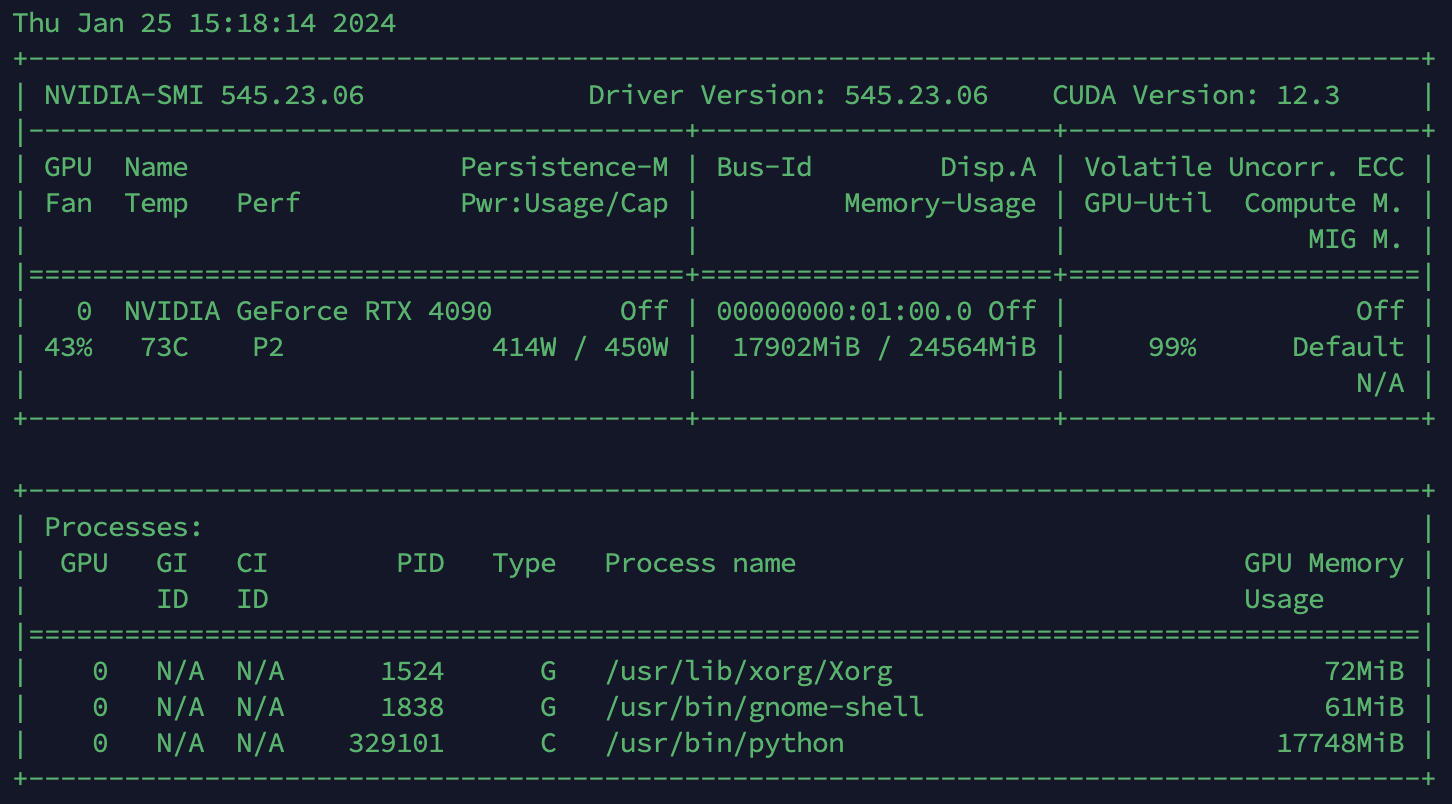
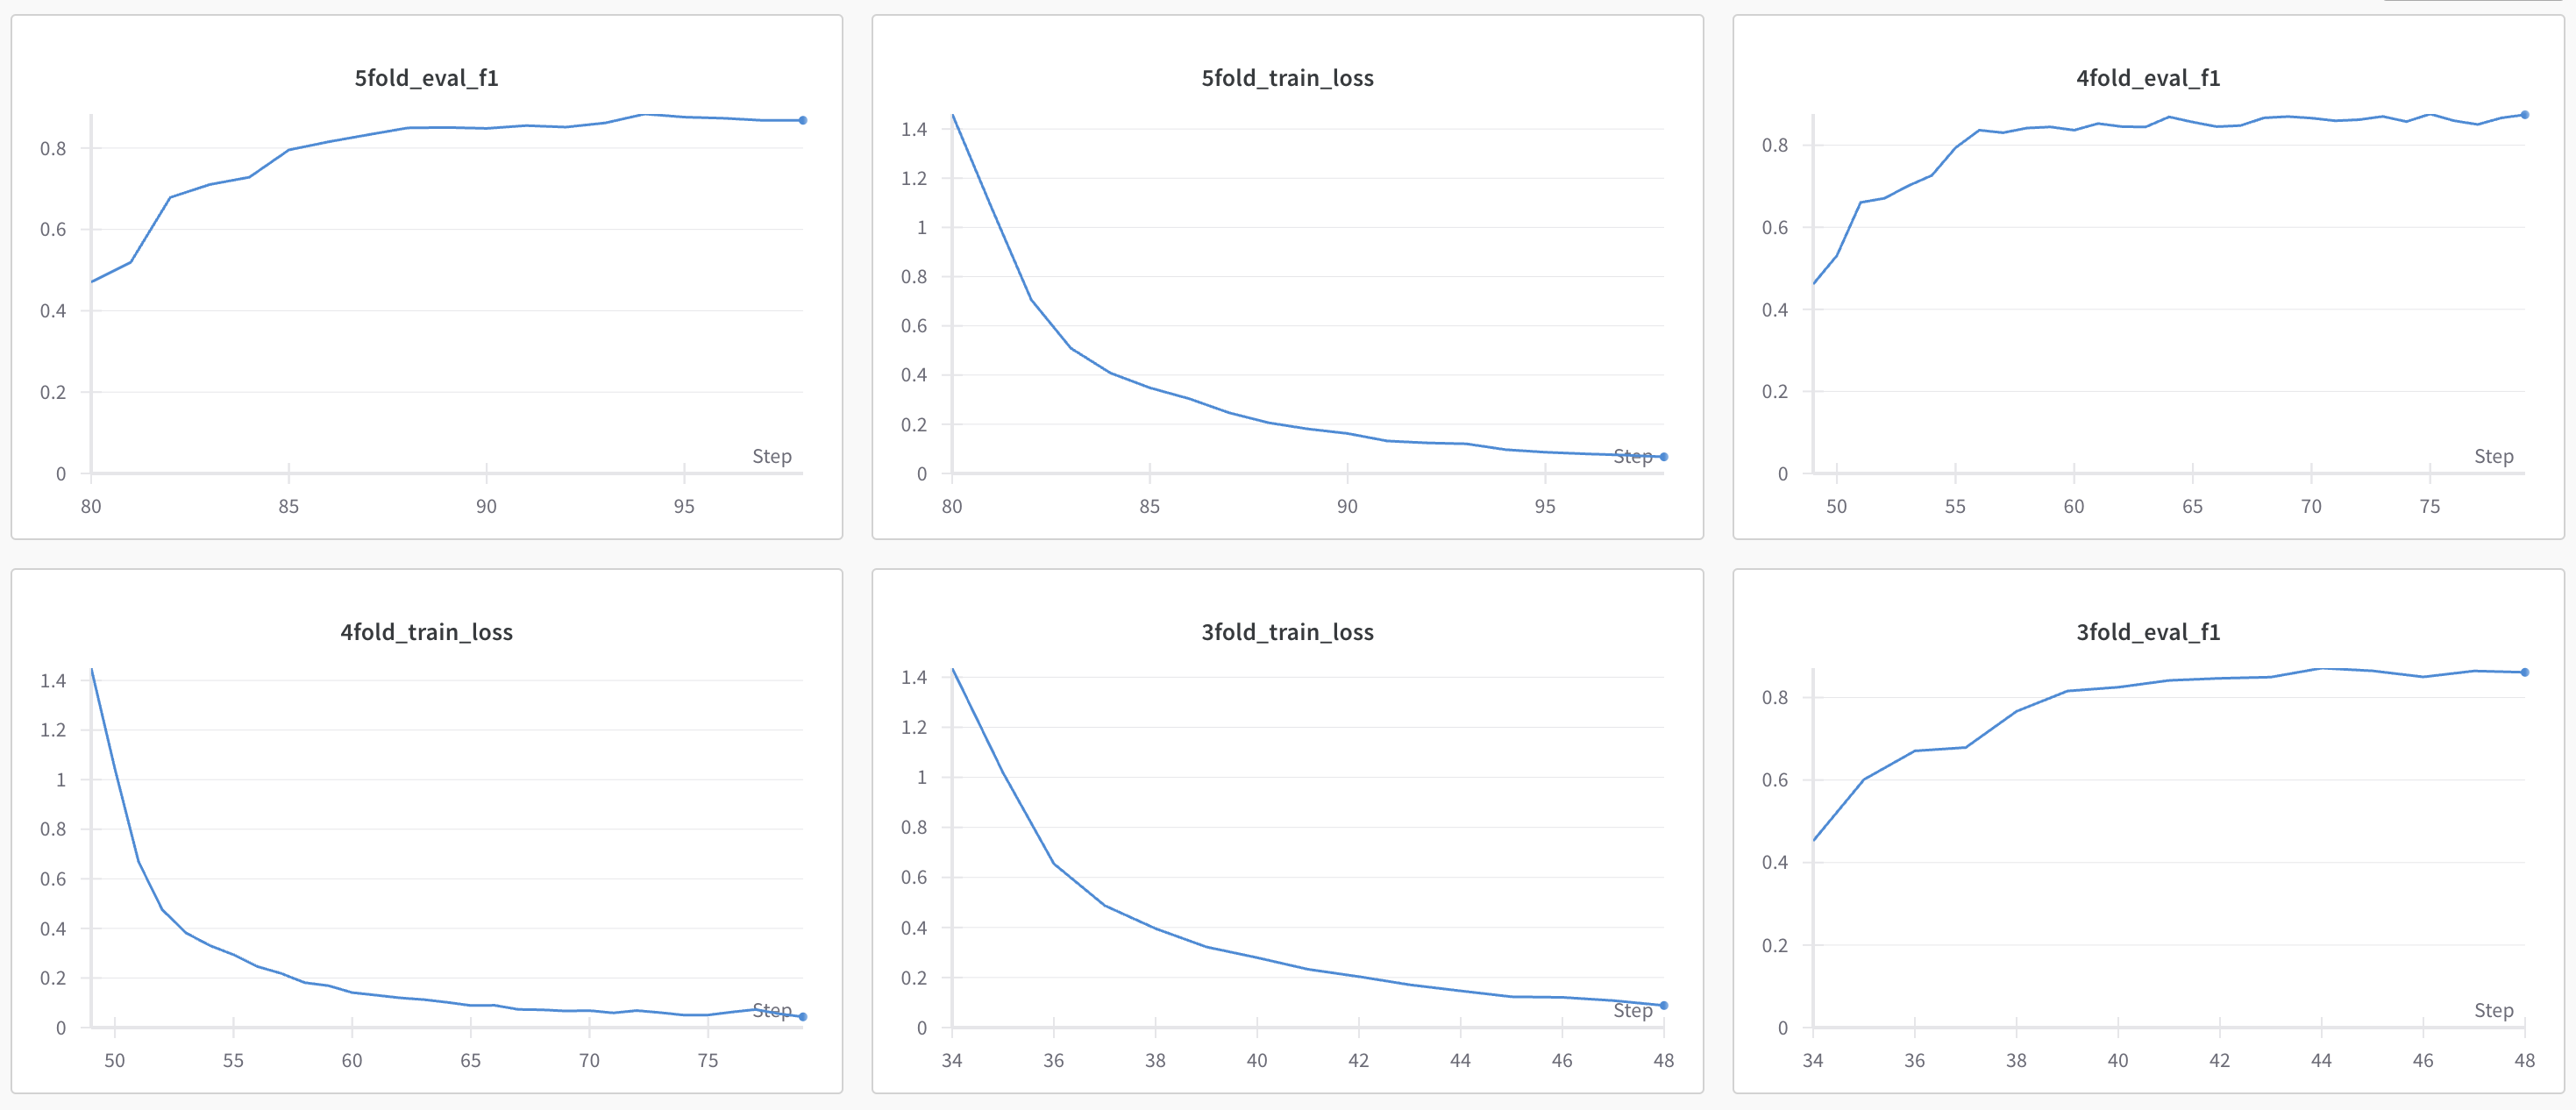

### 모델 평가

- test셋을 이용하여 모델을 평가합니다.
- k개의 모델으로 평가한 결과를 평균내어 최종 f1-score를 확인합니다. (macro avg)
- gpt-4-turbo모델과 비교합니다.

In [27]:
from sklearn.metrics import f1_score
import json

# 테스트 데이터 로드 및 처리
test_file_name = '/media/mydrive/datasets/text_classification_test.jsonl'
test_texts, test_labels = load_and_process_data(test_file_name, label_map)
tokenized_test = tokenize_data(test_texts)
test_dataset = create_dataset(tokenized_test, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Test dataset: {len(test_dataset)}")

label_map_inv = {0: "꿈", 1: "일기", 2: "일정", 3: "메모", 4: "오류"}

# 모델 평가
f1_scores = []

for kfold in range(1, k + 1):
    # 모델 로드
    model = ElectraForSequenceClassification.from_pretrained(f"/media/mydrive/models/text_classification/model_{kfold}", num_labels=len(label_map)).to(device)
    model.eval()

    all_preds = []
    all_true = []
    logged_data = []
    id_counter = 1

    with torch.no_grad():
        for batch in test_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = [b.to(device) for b in batch]

            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_true.extend(batch_labels.cpu().numpy())

            # 입력과 출력을 logged_data에 추가
            for input_id, true_label, pred_label in zip(batch_input_ids, batch_labels, preds):
                logged_data.append({
                    "id": id_counter,
                    "input": tokenizer.decode(input_id, skip_special_tokens=True),
                    "output": label_map_inv[true_label.item()],
                    "predicted": label_map_inv[pred_label],
                })
                id_counter += 1

        # logged_data를 jsonl 파일로 저장
        file_name = f"/media/mydrive/datasets/text_classification_fold_{kfold}_test.jsonl"
        with open(file_name, 'w', encoding='utf-8') as f:
            for data in logged_data:
                json.dump(data, f, ensure_ascii=False)
                f.write('\n')

    # F1 스코어 계산
    f1 = f1_score(all_true, all_preds, average="macro")
    f1_scores.append(f1)
    print(f"F1 Score for fold {kfold}: {f1}")

# 최종 평균 F1 스코어
average_f1 = sum(f1_scores) / len(f1_scores)
print(f"Average F1 Score: {average_f1}")

Test dataset: 536
F1 Score for fold 1: 0.9579168072253672
F1 Score for fold 2: 0.9614135559040007
F1 Score for fold 3: 0.9506633558716269
F1 Score for fold 4: 0.94866333629038
F1 Score for fold 5: 0.9420034775694255
Average F1 Score: 0.9521321065721601


In [28]:
# 데이터 확인
with open('/media/mydrive/datasets/text_classification_fold_1_test.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        line = json.loads(line)
        if line["output"] != line["predicted"]:
            print(line)

{'id': 23, 'input': '내가 너한테 어떤 프롬프트를 작성해서 역할을 부여했더라?', 'output': '오류', 'predicted': '꿈'}
{'id': 103, 'input': '환승연애 3을 봤는데 너무 재밌다', 'output': '일기', 'predicted': '메모'}
{'id': 136, 'input': '커다란 모기가 나를 물어서 이마에 혹이 났어.', 'output': '일기', 'predicted': '꿈'}
{'id': 139, 'input': '조태완', 'output': '메모', 'predicted': '오류'}
{'id': 149, 'input': '3월 2일 개강', 'output': '일정', 'predicted': '오류'}
{'id': 191, 'input': '1월 30일 수화', 'output': '일정', 'predicted': '메모'}
{'id': 232, 'input': '일정 등록하고 싶어', 'output': '오류', 'predicted': '메모'}
{'id': 275, 'input': '옆집 이웃과 낯술 한잔 볼수록 훌륭한 분들 곁에 이렇게 훌륭한 분들이 계셔서 행복함', 'output': '일기', 'predicted': '일정'}
{'id': 284, 'input': '내가 너한테 어떤 프롬프트를 작성해서 역할을 부여했더라?', 'output': '오류', 'predicted': '꿈'}
{'id': 343, 'input': '99월 42일 전우진 생일', 'output': '오류', 'predicted': '메모'}
{'id': 413, 'input': '29일 30일 오전', 'output': '일정', 'predicted': '오류'}
{'id': 429, 'input': '친구들과 동남아에 가서 골프를 치고 싶다. 여긴 추우니까.', 'output': '일기', 'predicted': '꿈'}
{'id': 510, 'input': '2024 켈린더구매', 'output': '메모

500개의 데이터를 분석해본 결과 기존 gpt-4-turbo모델로 텍스트를 분류했을 때

평균적으로 1개의 작업 당
- 16.47원(2023.01.25 기준)의 비용이 들었습니다.
- 1.32초의 시간이 걸렸습니다.

f1-score는 0.673입니다.(but, 기존 방식에는 라벨의 갯수가 4개였다.)
분류 정확도는 82.75%입니다.

beomi/KcELECTRA-base-v2022 모델을 직접 학습해서 사용 시 평균 f1-score는 0.952입니다.

이로써 기존 방식에 비해 매우 저렴한 비용으로 더 높은 정확도(f1-score기준: 1.4배)를 얻을 수 있습니다.

In [33]:
!huggingface-cli login

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: Traceback (most recent call last):
  File "/home/dmz/.local/bin/huggingface-cli", li

In [35]:
# 허깅페이스에 모델 업로드
sota_model = 2
model = ElectraForSequenceClassification.from_pretrained(f"/media/mydrive/models/text_classification/model_{sota_model}")

model.save_pretrained("/media/mydrive/models/text_classification/huggingface_model")
model.push_to_hub("text-classification-v1.0", use_auth_token=True, private=True)

pytorch_model.bin: 100%|████████████████████████████████████████████| 511M/511M [00:56<00:00, 9.13MB/s]


CommitInfo(commit_url='https://huggingface.co/taewan2002/text-classification-v1.0/commit/c5da8a8e660ffaba6729476edafed4d1318c0dc9', commit_message='Upload ElectraForSequenceClassification', commit_description='', oid='c5da8a8e660ffaba6729476edafed4d1318c0dc9', pr_url=None, pr_revision=None, pr_num=None)

![Screenshot 2024-01-25 at 6.54.15 PM.png](<attachment:Screenshot 2024-01-25 at 6.54.15 PM.png>)
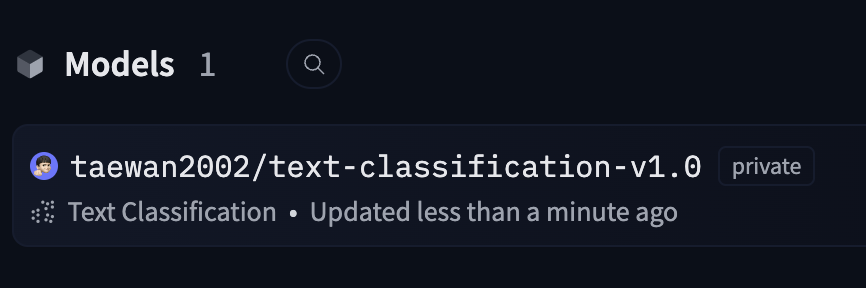